# Logistic Regression: A Sentiment Analysis Case Study

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/sentiment-analysis-logistic-regression')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


### Introduction
___

- IMDB movie reviews dataset
- http://ai.stanford.edu/~amaas/data/sentiment
- Contains 25000 positive and 25000 negative reviews
- At least 7 stars out of 10 $\rightarrow$ positive (label = 1)
- At most 4 stars out of 10 $\rightarrow$ negative (label = 0)
- 50/50 train/test split
- Evaluation accuracy

<b>Features: bag of 1-grams with TF-IDF values</b>:
- Extremely sparse feature matrix - close to 97% are zeros

 <b>Model: Logistic regression</b>
- $p(y = 1|x) = \sigma(w^{T}x)$
- Linear classification model
- Can handle sparse data
- Fast to train
<img src="https://i.imgur.com/VieM41f.png">

### Loading the dataset
---

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('movie_data.csv')
df.head(5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


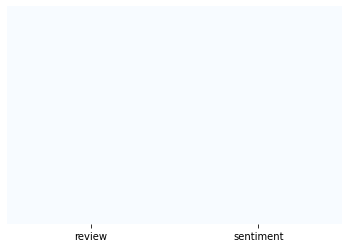

In [3]:
# check if null values exist
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues");

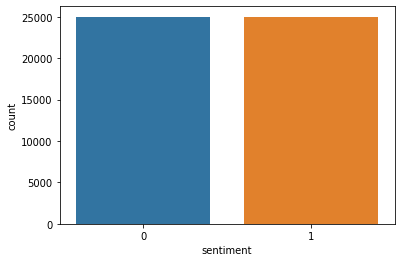

In [4]:
sns.countplot(df['sentiment'], label = "Count");

In [5]:
df['length'] = df['review'].apply(len)

In [6]:
df.head()

,review,sentiment,length
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1,1393
1,OK... so... I really like Kris Kristofferson a...,0,1257
2,"***SPOILER*** Do not read this, if you think a...",0,1678
3,hi for all the people who have seen this wonde...,1,381
4,"I recently bought the DVD, forgetting just how...",0,698


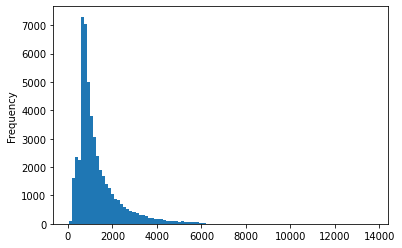

In [7]:
df['length'].plot(bins=100, kind='hist');

In [8]:
df.describe()

,sentiment,length
count,50000.000000,50000.000000
mean,0.500000,1309.431020
std,0.500005,989.728014
min,0.000000,32.000000
25%,0.000000,699.000000
50%,0.500000,970.000000
75%,1.000000,1590.250000
max,1.000000,13704.000000


## Bag of words / Bag of N-grams model

### Transforming documents into feature vectors

Below, we will call the fit_transform method on CountVectorizer. This will construct the vocabulary of the bag-of-words model and transform the following three sentences into sparse feature vectors:
1. The sun is shining
2. The weather is sweet
3. The sun is shining, the weather is sweet, and one and one is two


In [9]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
docs = np.array([
        'The sun is shining',
        'The weather is sweet',
        'The sun is shining, the weather is sweet, and one and one is two'])
bag = count.fit_transform(docs)

In [10]:
print(count.vocabulary_)

{'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}


In [11]:
print(bag.toarray())

[[0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 1]
 [2 3 2 1 1 1 2 1 1]]


Raw term frequencies: *tf (t,d)*—the number of times a term t occurs in a document *d*

### Word relevancy using term frequency-inverse document frequency

$$\text{tf-idf}(t,d)=\text{tf (t,d)}\times \text{idf}(t,d)$$

$$\text{idf}(t,d) = \text{log}\frac{n_d}{1+\text{df}(d, t)},$$

where $n_d$ is the total number of documents, and df(d, t) is the number of documents d that contain the term t.

In [12]:
np.set_printoptions(precision=2)

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
print(tfidf.fit_transform(count.fit_transform(docs)).toarray())

[[0.   0.43 0.   0.56 0.56 0.   0.43 0.   0.  ]
 [0.   0.43 0.   0.   0.   0.56 0.43 0.   0.56]
 [0.5  0.45 0.5  0.19 0.19 0.19 0.3  0.25 0.19]]


The equations for the idf and tf-idf that are implemented in scikit-learn are:

$$\text{idf} (t,d) = log\frac{1 + n_d}{1 + \text{df}(d, t)}$$
The tf-idf equation that is implemented in scikit-learn is as follows:

$$\text{tf-idf}(t,d) = \text{tf}(t,d) \times (\text{idf}(t,d)+1)$$

$$v_{\text{norm}} = \frac{v}{||v||_2} = \frac{v}{\sqrt{v_{1}^{2} + v_{2}^{2} + \dots + v_{n}^{2}}} = \frac{v}{\big (\sum_{i=1}^{n} v_{i}^{2}\big)^\frac{1}{2}}$$

### Example:
$$\text{idf}("is", d3) = log \frac{1+3}{1+3} = 0$$
Now in order to calculate the tf-idf, we simply need to add 1 to the inverse document frequency and multiply it by the term frequency:

$$\text{tf-idf}("is",d3)= 3 \times (0+1) = 3$$

### Calculate tf-idf of the term *is*:

In [14]:
tf_is = 3
n_docs = 3
idf_is = np.log((n_docs+1) / (3+1))
tfidf_is = tf_is * (idf_is + 1)
print('tf-idf of term "is" = %.2f' % tfidf_is)

tf-idf of term "is" = 3.00


$$\text{tfi-df}_{norm} = \frac{[3.39, 3.0, 3.39, 1.29, 1.29, 1.29, 2.0 , 1.69, 1.29]}{\sqrt{[3.39^2, 3.0^2, 3.39^2, 1.29^2, 1.29^2, 1.29^2, 2.0^2 , 1.69^2, 1.29^2]}}$$$$=[0.5, 0.45, 0.5, 0.19, 0.19, 0.19, 0.3, 0.25, 0.19]$$$$\Rightarrow \text{tfi-df}_{norm}("is", d3) = 0.45$$

In [15]:
tfidf = TfidfTransformer(use_idf=True, norm=None, smooth_idf=True)
raw_tfidf = tfidf.fit_transform(count.fit_transform(docs)).toarray()[-1]
raw_tfidf

array([3.39, 3.  , 3.39, 1.29, 1.29, 1.29, 2.  , 1.69, 1.29])

In [16]:
l2_tfidf = raw_tfidf / np.sqrt(np.sum(raw_tfidf**2))
l2_tfidf

array([0.5 , 0.45, 0.5 , 0.19, 0.19, 0.19, 0.3 , 0.25, 0.19])

### Data Preparation

In [17]:
df.loc[0, 'review'][-50:]

'is seven.<br /><br />Title (Brazil): Not Available'

In [18]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

In [19]:
preprocessor(df.loc[0, 'review'][-50:])

'is seven title brazil not available'

In [20]:
preprocessor("</a>This :) is :( a test :-)!")

'this is a test :) :( :)'

In [21]:
df['review'] = df['review'].apply(preprocessor)

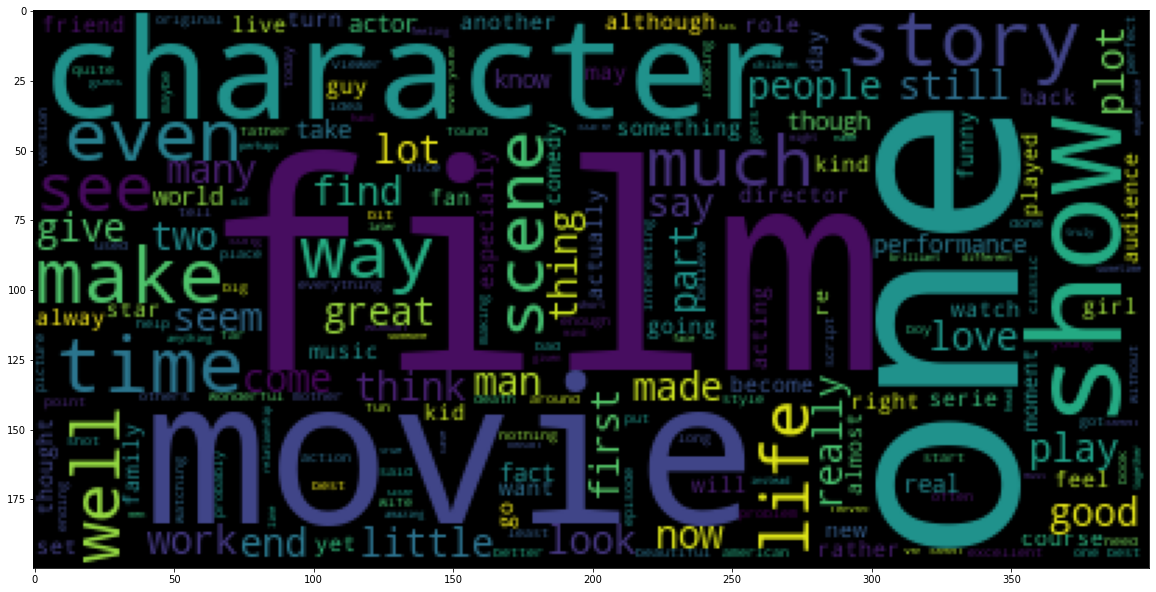

In [22]:
# Wordcloud for POSIIVE reviews

from wordcloud import WordCloud

positive_sentences = df.loc[df['sentiment'] == 1]['review'].tolist()
positive_sentences_as_one_string =" ".join(positive_sentences)

plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(positive_sentences_as_one_string));

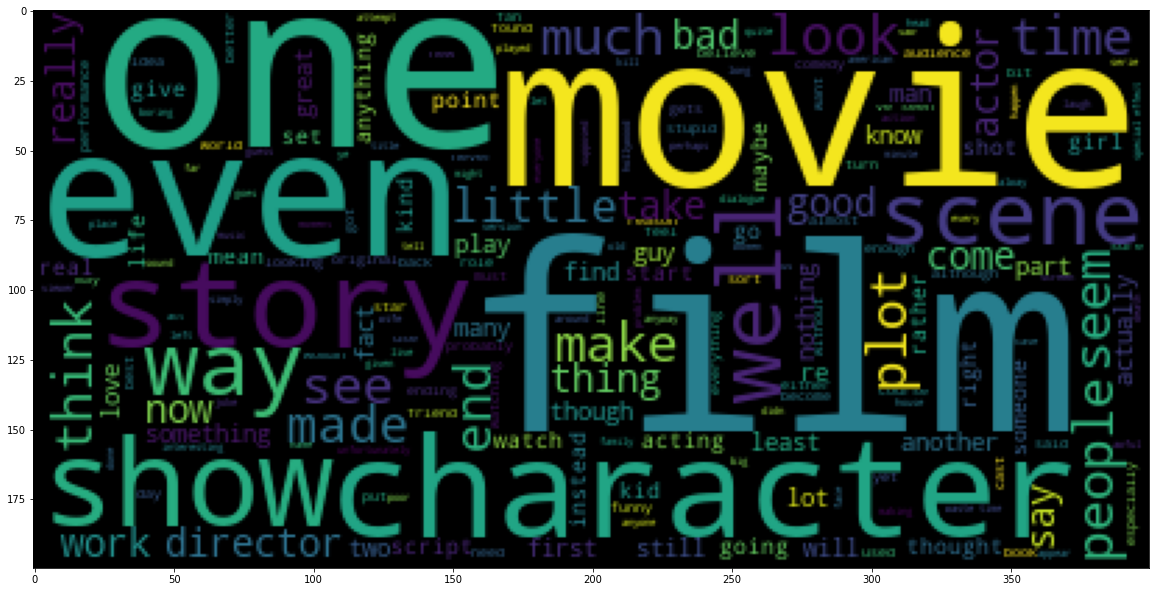

In [37]:
# Wordcloud for NEGATIVE reviews

negative_sentences = df.loc[df['sentiment'] == 0]['review'].tolist()
negative_sentences_as_one_string =" ".join(negative_sentences)

plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(negative_sentences_as_one_string));

### Tokenization of documents

In [24]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
    return text.split()


def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [25]:
tokenizer('runners like running and thus they run')

['runners', 'like', 'running', 'and', 'thus', 'they', 'run']

In [26]:
tokenizer_porter('runners like running and thus they run')

['runner', 'like', 'run', 'and', 'thu', 'they', 'run']

In [27]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [28]:
from nltk.corpus import stopwords

stop = stopwords.words('english')
[w for w in tokenizer_porter('a runner likes running and runs a lot')[-10:] if w not in stop]

['runner', 'like', 'run', 'run', 'lot']

### Document classification via a logistic regression model

In [29]:
X_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

In [30]:
print("Review: ", X_train[1], "\n")
print("Sentiment: ", y_train[1])

Review:  ok so i really like kris kristofferson and his usual easy going delivery of lines in his movies age has helped him with his soft spoken low energy style and he will steal a scene effortlessly but disappearance is his misstep holy moly this was a bad movie i must give kudos to the cinematography and and the actors including kris for trying their darndest to make sense from this goofy confusing story none of it made sense and kris probably didn t understand it either and he was just going through the motions hoping someone would come up to him and tell him what it was all about i don t care that everyone on this movie was doing out of love for the project or some such nonsense i ve seen low budget movies that had a plot for goodness sake this had none zilcho nada zippo empty of reason a complete waste of good talent scenery and celluloid i rented this piece of garbage for a buck and i want my money back i want my 2 hours back i invested on this grade f waste of my time don t wat

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

In [ ]:
gs_lr_tfidf.fit(X_train, y_train)

### Model accuracy

In [33]:
print('Best parameter set: %s' % gs_lr_tfidf.best_params_)
print('CV Accuracy:%.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x7f07b507b950>}
CV Accuracy:0.897


In [34]:
clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Test Accuracy: 0.899


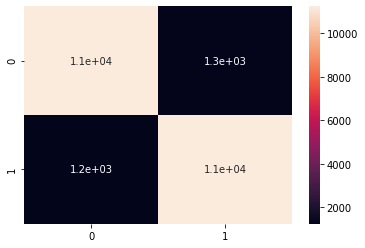

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

y_predict_test = clf.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True);

In [36]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     12527
           1       0.90      0.90      0.90     12473

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

